In [ ]:
import os
import psycopg
from datetime import date
from googleapiclient.discovery import build
from dotenv import load_dotenv
from tqdm import tqdm
from colorama import Style,Fore

load_dotenv()

# Collecter et enregistrer les métriques des chaînes

- On va collecter et enregistrer en même temps les métriques de chaque chaîne pertinente (en évitant de passer par un JSON).


In [ ]:
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY1"))

In [ ]:
def getMetrics(id_chaine):
    request = youtube.channels().list(
        part='statistics',
        id=id_chaine
    )
    response = request.execute()
    
    if not response['items']:
        return None
    
    stats = response['items'][0]['statistics']
    date_releve_chaine = date.today().isoformat()
    nombre_vues_total = int(stats.get('viewCount', 0))
    nombre_abonnes_total = int(stats.get('subscriberCount', 0))
    nombre_videos_total = int(stats.get('videoCount', 0))
    
    return {
        'date_releve_chaine': date_releve_chaine,
        'nombre_vues_total': nombre_vues_total,
        'nombre_abonnes_total': nombre_abonnes_total,
        'nombre_videos_total': nombre_videos_total
    }

In [ ]:
getMetrics("UCVQeGg4Fdrrr8vDXa7yjOYg")

In [ ]:
conn = psycopg.connect(
    dbname="youtubestay",
    user="postgres",
    password=os.getenv("POSTGRE_PASSWORD"),
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# Récupérer les chaînes pertinentes
cur.execute("SELECT id_chaine FROM chaines WHERE pertinente = TRUE")
chaines = cur.fetchall()


print(chaines)
print(len(chaines))

In [ ]:
# Pour chaque chaîne, récupérer et insérer les métriques
for (id_chaine,) in chaines:
    metriques = getMetrics(id_chaine)
    if metriques:
        cur.execute("""
            INSERT INTO chaines_metriques (
                id_chaine, date_releve_chaine,
                nombre_vues_total, nombre_abonnes_total, nombre_videos_total
            )
            VALUES (%s, %s, %s, %s, %s)
            ON CONFLICT (id_chaine, date_releve_chaine) DO NOTHING
        """, (
            id_chaine,
            metriques['date_releve_chaine'],
            metriques['nombre_vues_total'],
            metriques['nombre_abonnes_total'],
            metriques['nombre_videos_total']
        ))

conn.commit()
cur.close()
conn.close()

# Calcul de la couverture

In [ ]:
def get_couverture(id_chaine,conn):
    
    cur = conn.cursor()

    # Récupérer le nombre de vidéos collectées
    cur.execute("""
        SELECT COUNT(*) FROM videos
        WHERE id_chaine = %s AND requetes IS NOT NULL;
    """, (id_chaine,))
    nb_collectees = cur.fetchone()[0]

    # Récupérer le nombre total de vidéos le plus récent
    cur.execute("""
        SELECT nombre_videos_total
        FROM chaines_metriques
        WHERE id_chaine = %s
        ORDER BY date_releve_chaine DESC
        LIMIT 1
    """, (id_chaine,))
    row = cur.fetchone()


    if not row:
        return None  # Pas de métrique pour cette chaîne

    nb_total = row[0]

    if nb_total == 0:
        return 0.0  # Évite division par zéro

    couverture = nb_collectees / nb_total
    return nb_collectees,nb_total,round(couverture, 3)


In [ ]:
conn = psycopg.connect(
        dbname="youtubestay",
        user="postgres",
        password=os.getenv("POSTGRE_PASSWORD"),
        host="localhost",
        port="5432"
    )

nb_collectees,nb_total,couverture = get_couverture("UCxBJustR1tuXVy7tLivER2g",conn)


print("Nombre de vidéos pertinentes dans la base de données",nb_collectees)
print("Nombre de vidéos total de la chaîne",nb_total)
print("Couverture :", couverture)

conn.close()


In [ ]:
import psycopg
import os
import json
from tqdm import tqdm

def get_couverture_moyenne():
    conn = psycopg.connect(
        dbname="youtubestay",
        user="postgres",
        password=os.getenv("POSTGRE_PASSWORD"),
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()

    cur.execute("""
        SELECT id_chaine FROM chaines WHERE pertinente = TRUE
    """)
    chaines = cur.fetchall()

    total = 0.0
    count = 0
    resultats = []

    for (id_chaine,) in tqdm(chaines):
        nb_collectees, nb_total, couverture = get_couverture(id_chaine, conn)
        resultats.append({
            "id_chaine": id_chaine,
            "nb_collectees": nb_collectees,
            "nb_total": nb_total,
            "couverture": couverture
        })
        if couverture is not None:
            total += couverture
            count += 1

    conn.close()
    
    resultats.sort(key=lambda x: (x["couverture"] is not None, x["couverture"]), reverse=True)
    
    with open("couverture_par_chaine.json", "w", encoding="utf-8") as f:
        json.dump(resultats, f, indent=2, ensure_ascii=False)

    if count == 0:
        return 0.0
    return round(total / count, 3)


In [ ]:
get_couverture_moyenne()

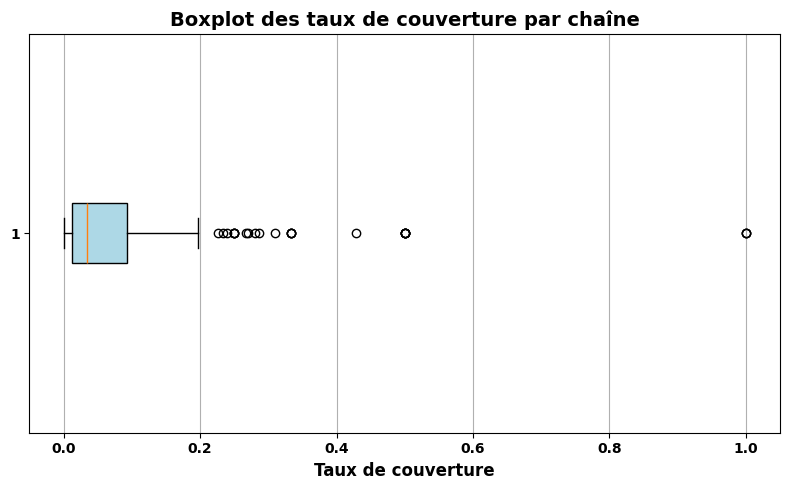

In [4]:
import json
import matplotlib.pyplot as plt

with open("couverture_par_chaine.json", "r", encoding="utf-8") as f:
    data = json.load(f)

couvertures = [item["couverture"] for item in data if item["couverture"] is not None]

plt.figure(figsize=(8, 5))
plt.boxplot(couvertures, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title("Boxplot des taux de couverture par chaîne", fontsize=14, fontweight='bold')
plt.xlabel("Taux de couverture", fontsize=12, fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')  # Ticks axe x en gras
plt.yticks(fontsize=10, fontweight='bold')  # Ticks axe y en gras

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()




In [2]:
import json
import numpy as np

with open("couverture_par_chaine.json", "r", encoding="utf-8") as f:
    data = json.load(f)

couvertures = [item["couverture"] for item in data if item["couverture"] is not None]

q1 = round(np.percentile(couvertures, 25), 3)
median = round(np.percentile(couvertures, 50), 3)
q3 = round(np.percentile(couvertures, 75), 3)

print(f"Q1 (25e percentile)  : {q1}")
print(f"Médiane (50e percentile): {median}")
print(f"Q3 (75e percentile)  : {q3}")


Q1 (25e percentile)  : 0.012
Médiane (50e percentile): 0.034
Q3 (75e percentile)  : 0.093


# Enrichissement des vidéos

In [ ]:
from googleapiclient.discovery import build
import re
import scrapetube

youtube = build("youtube", "v3", developerKey=os.getenv("YOUTUBE_API_Nou2008"))

In [ ]:

def getVideosIdsYoutubeAPI(channel_id):

    channel_response = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()

    uploads_playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    video_ids = []
    next_page_token = None

    while True:
        playlist_response = youtube.playlistItems().list(
            part='snippet',
            playlistId=uploads_playlist_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()

        for item in playlist_response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            video_ids.append(video_id)

        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

    return video_ids

def toSeconds(iso_duration):
    # Exemple : "PT50M11S" → 3011 secondes
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', iso_duration)
    if not match:
        return None
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0
    return hours * 3600 + minutes * 60 + seconds

def getvideos_details_bunch(video_ids):
    try:
        
        request = youtube.videos().list(
            part='snippet,contentDetails',
            id=','.join(video_ids[:50])  # Max 50 IDs per request
        )
        response = request.execute()
    except Exception as e:
        print(f"probleme with request  {e}")

    videos_metadata = []

    for item in response.get('items', []):
        video_metadata = {
            'id_video': item['id'],
            'id_chaine': item['snippet']['channelId'],
            'titre_video': item['snippet']['title'],
            'description': item['snippet'].get('description', ''),
            'date_publication': item['snippet']['publishedAt'],
            'duree': item['contentDetails']['duration'],
            'miniature': '',
            'tags': '',
            'langue': 'fr'
        }

        resolution_order = ["maxres", "standard", "high", "medium", "default"]
        for res in resolution_order:
            if res in item['snippet'].get('thumbnails', {}):
                video_metadata['miniature'] = item['snippet']['thumbnails'][res]['url']
                break

        if 'tags' in item['snippet']:
            video_metadata['tags'] = item['snippet']['tags']

        videos_metadata.append(video_metadata)

    return videos_metadata


In [ ]:
ids = getVideosIdsYoutubeAPI("UCITV77iHSp-2_cgwdZNaxKQ")
len(ids)

In [ ]:
conn = psycopg.connect(
    dbname="youtubestay",
    user="postgres",
    password=os.getenv("POSTGRE_PASSWORD"),
    host="localhost",
    port="5432"
)

cur = conn.cursor()

In [ ]:
getvideos_details_bunch(ids)

In [ ]:
cur.execute("""
    SELECT id_chaine FROM chaines WHERE pertinente = TRUE
""")

chaines_pertinentes = cur.fetchall()

for (id_chaine,) in tqdm(chaines_pertinentes): 
    videos_ids = getVideosIdsYoutubeAPI(id_chaine)
    
    for i in range(0, len(videos_ids), 50):
        batch_ids = videos_ids[i:i+50]  # Paquet de 50 IDs max
        videos = getvideos_details_bunch(batch_ids)
      
        data_to_insert = []

        for video in videos:
            id_video = video["id_video"]
            id_chaine = video["id_chaine"]
            titre = video["titre_video"]
            description = video["description"]
            date_publication = video["date_publication"][:10]  # 'YYYY-MM-DD'
            duree = toSeconds(video["duree"])
            miniature = video["miniature"]
            langue = video["langue"]
            transcription = None
            tags = video["tags"] if isinstance(video["tags"], list) else None
            requetes = None
            categorie_video = None

            data_to_insert.append((
                id_video, titre, description, date_publication, categorie_video,
                duree, miniature, langue, transcription, tags, requetes, id_chaine
            ))

        if data_to_insert:
            cur.executemany("""
                INSERT INTO videos (
                    id_video, titre, description, date_publication, categorie_video,
                    duree, miniature, langue, transcription, tags, requetes, id_chaine
                ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                ON CONFLICT (id_video) DO NOTHING
            """, data_to_insert)


In [ ]:
conn.commit()
cur.close()
conn.close()

# Collecter et enregistrer les métriques des vidéos

In [ ]:
youtube = build("youtube", "v3", developerKey=os.getenv("YOUTUBE_API_Mono"))

In [ ]:
43000/50

- Every call of this function cost only 1 youtube unit
- I have as limit 10 000 unit per day but there are about 43 000 videos, i can group them to batchs of 50 videos => 860 batch => 860 unit !

In [ ]:
def getMetrics_batch(batch_ids):
    
    resultats = []
    date_releve = date.today().isoformat()
    
    try:
        response = youtube.videos().list(
            part="statistics",
            id=",".join(batch_ids)
        ).execute()

        for item in response.get("items", []):
            stats = item["statistics"]
            resultats.append({
                "id_video": item["id"],
                "date_releve_video": date_releve,
                "nombre_vues": int(stats.get("viewCount", 0)),
                "nombre_likes": int(stats.get("likeCount", 0)) if "likeCount" in stats else None
            })

    except Exception as e:
        print(f"Erreur avec le lot {batch_ids}: {e}")

    return resultats

def getMetrics_videos():
    conn = psycopg.connect(
        dbname="youtubestay",
        user="postgres",
        password=os.getenv("POSTGRE_PASSWORD"),
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()

    cur.execute("SELECT id_video FROM videos")
    all_ids = [row[0] for row in cur.fetchall()]

    for i in range(0, len(all_ids), 50):
        batch = all_ids[i:i + 50]
        metriques = getMetrics_batch(batch)

        for m in metriques:
            cur.execute("""
                INSERT INTO videos_metriques (id_video, date_releve_video, nombre_vues, nombre_likes)
                VALUES (%s, %s, %s, %s)
                ON CONFLICT (id_video, date_releve_video) DO NOTHING
            """, (m["id_video"], m["date_releve_video"], m["nombre_vues"], m["nombre_likes"]))

        conn.commit()
        print(f"Batch {i // 50 + 1} inséré")

    cur.close()
    conn.close()



## Test

In [ ]:
conn = psycopg.connect(
    dbname="youtubestay",
    user="postgres",
    password=os.getenv("POSTGRE_PASSWORD"),
    host="localhost",
    port="5432"
)

In [ ]:
cur = conn.cursor()
cur.execute("SELECT id_video FROM videos LIMIT 50")
rows = cur.fetchall()
cur.close()
conn.close()

video_ids = [row[0] for row in rows]

In [ ]:
results = getMetrics_batch(video_ids)

In [ ]:
print(len(results))
print(results)

## Run all

In [ ]:
getMetrics_videos()

# Collecter et enregistrer les commentaires

In [ ]:
index = 1
APIsNames = ["YOUTUBE_API_Mono",
             "YOUTUBE_API_Mono1",
             "YOUTUBE_API_Tecnom",
             "YOUTUBE_API_Tecnom1",
             "YOUTUBE_API_Zegaga",
              "YOUTUBE_API_Zegaga1",
             "YOUTUBE_API_Nour",
             "YOUTUBE_API_Nour1"
             ]
youtube = build('youtube', 'v3', developerKey=os.getenv(APIsNames[index]))
index+=1

- La fonction coûtera au minimum 1 unité par vidéo selon le nombre de commentaires. S’il s’agit de 1 unité par vidéo, on aura alors besoin d’environ 43 000 unités, car on a à peu près 43 000 vidéos.


In [ ]:
import re

def get_commentaires_video(id_video):
    commentaires = []
    global youtube, index
    
    try:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=id_video,
            maxResults=100,
            textFormat="plainText"
        )

        while request:
            response = request.execute()

            for item in response.get("items", []):
                top_comment_item = item["snippet"]["topLevelComment"]
                top_snippet = top_comment_item["snippet"]

                commentaire_id = top_comment_item["id"]
                utilisateur_id = top_snippet.get("authorChannelId", {}).get("value", "anonyme")
                nom_utilisateur = top_snippet.get("authorDisplayName", "inconnu")

                commentaires.append({
                    "id_commentaire": commentaire_id,
                    "contenu": top_snippet["textDisplay"],
                    "date_commentaire": top_snippet["publishedAt"][:10],
                    "id_video": id_video,
                    "id_utilisateur": utilisateur_id,
                    "nom_utilisateur": nom_utilisateur,
                    "id_commentaire_parent": None
                })

                replies = item.get("replies", {}).get("comments", [])
                for reply in replies:
                    reply_snippet = reply["snippet"]
                    reply_id = reply["id"]
                    reply_utilisateur_id = reply_snippet.get("authorChannelId", {}).get("value", "anonyme")
                    reply_nom_utilisateur = reply_snippet.get("authorDisplayName", "inconnu")

                    commentaires.append({
                        "id_commentaire": reply_id,
                        "contenu": reply_snippet["textDisplay"],
                        "date_commentaire": reply_snippet["publishedAt"][:10],
                        "id_video": id_video,
                        "id_utilisateur": reply_utilisateur_id,
                        "nom_utilisateur": reply_nom_utilisateur,
                        "id_commentaire_parent": commentaire_id
                    })

            request = youtube.commentThreads().list_next(request, response)

    except Exception as e:
        
        match = re.search(r"'reason':\s*'([^']+)'", str(e))
        
        if match:
            if match.group(1) == 'commentsDisabled':
                print(f"Erreur : {match.group(1)}")
                
            if match.group(1) == 'quotaExceeded':
                youtube = build('youtube', 'v3', developerKey=os.getenv(APIsNames[index]))
                print(Style.BRIGHT + Fore.GREEN + f"api key switched to {APIsNames[index]}")
                index+=1
                
        else:
            print(f"Erreur lors de la récupération des commentaires : {e}")

    return commentaires


## Test

In [ ]:
comments = get_commentaires_video('MPHFPu8zAlU')
len(comments)

In [ ]:
comments

## Run all

In [ ]:
def getComments():
    
    conn = psycopg.connect(
        dbname="youtubestay",
        user="postgres",
        password=os.getenv("POSTGRE_PASSWORD"),
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()
    
    cur.execute("SELECT * FROM videos order by duree desc;")
    video_ids = [row[0] for row in cur.fetchall()]
    
    for video_id in tqdm(video_ids[25690:]):
        commentaires = get_commentaires_video(video_id)

        for commentaire in commentaires:
            try:
                # Insert user
                cur.execute("""
                    INSERT INTO utilisateurs (id_utilisateur, nom_utilisateur)
                    VALUES (%s, %s)
                    ON CONFLICT (id_utilisateur) DO NOTHING
                """, (
                    commentaire["id_utilisateur"],
                    commentaire["nom_utilisateur"]
                ))

                # Insert comment
                cur.execute("""
                INSERT INTO commentaires (
                    id_commentaire,
                    contenu,
                    date_commentaire,
                    id_video,
                    id_utilisateur,
                    id_commentaire_parent
                )
                VALUES (%s, %s, %s, %s, %s, %s)
                ON CONFLICT (id_commentaire) DO NOTHING
            """, (
                commentaire["id_commentaire"],
                commentaire["contenu"],
                commentaire["date_commentaire"],
                commentaire["id_video"],
                commentaire["id_utilisateur"],
                commentaire["id_commentaire_parent"]
            ))
            except Exception as e:
                print(f"Skipped comment due to error: {e}")
        
        conn.commit()
        
    cur.close()
    conn.close()
    
# Run : we stoped in video at index 25690
# 

In [6]:
getComments()

 98%|█████████▊| 16800/17153 [1:10:57<00:39,  8.91it/s]

Erreur : commentsDisabled


 99%|█████████▊| 16938/17153 [1:11:22<00:38,  5.53it/s]

Erreur : commentsDisabled


 99%|█████████▉| 17015/17153 [1:11:34<00:21,  6.44it/s]

Erreur : commentsDisabled


 99%|█████████▉| 17051/17153 [1:11:40<00:13,  7.71it/s]

Erreur : commentsDisabled


100%|█████████▉| 17069/17153 [1:11:43<00:11,  7.03it/s]

Erreur : commentsDisabled


100%|█████████▉| 17138/17153 [1:11:55<00:02,  5.88it/s]

Erreur : commentsDisabled


100%|█████████▉| 17143/17153 [1:11:56<00:02,  4.91it/s]

Erreur : commentsDisabled


100%|██████████| 17153/17153 [1:11:57<00:00,  3.97it/s]


In [1]:
7000/370

18.91891891891892